# Restoring a model and making predictions with it

In [1]:
import os
import random

from helpers import get_files_path
from helpers import get_files_path2
from helpers import load_data

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.externals import joblib
import numpy as np

In [2]:
ROOT_DIR = os.getcwd()
DATA_DIR = 'C:\\Users\\srodri16\\Desktop\\german-traffic-signs'
TRAIN_DIR = os.path.join(DATA_DIR, 'training-set')
TEST_DIR = os.path.join(DATA_DIR, 'test-set')
SAVER_DIR = os.path.join(ROOT_DIR, "logs", "saver")
os.makedirs(SAVER_DIR, exist_ok = True)
SVC_FILE = os.path.join(SAVER_DIR, 'SVC.pkl')
PCA_FILE = os.path.join(SAVER_DIR, 'pca.pkl')

In [3]:
assert os.path.exists(TRAIN_DIR)
assert os.path.exists(TEST_DIR)
assert os.path.exists(SVC_FILE)
assert os.path.exists(PCA_FILE)

In [4]:
ipca = joblib.load(PCA_FILE)
clf = joblib.load(SVC_FILE)

In [5]:
test_files = get_files_path2(TEST_DIR, 5, 3)

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 1000.02it/s]


In [6]:
X_test, y_test = load_data(test_files)

100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 153.06it/s]


In [7]:
print(X_test.shape,y_test.shape)

(15, 32, 32, 3) (15,)


In [8]:
def getPredictions(imgs):
    X = np.reshape(imgs, newshape = (-1,32*32*3))
    X = ipca.transform(X)
    return clf.predict(X)

In [9]:
preds = getPredictions(X_test)

In [10]:
def show_samples_with_predictions(images, cls_true, cls_pred=None):
    """Show an image with its true class and predicted class"""
    n = int(np.ceil(len(cls_true)/3))
    # Create figure with 3xn sub-plots.
    fig, axes = plt.subplots(3, n)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i])

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}\nPred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

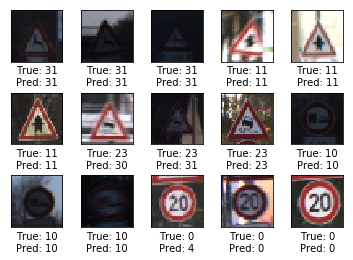

In [11]:
show_samples_with_predictions(X_test, y_test, preds)

In [12]:
## Performance measures

In [13]:
def print_confusion_matrix(cls_true, cls_pred, print_matrix = False, normalize = True):
    num_classes = 43
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # Print the confusion matrix as text.
    if print_matrix:
        print(cm)
        
    plt.rcParams['figure.figsize'] = 10, 10
    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [14]:
test_files = get_files_path(TEST_DIR)
X_test, y_test = load_data(test_files)

100%|███████████████████████████████████| 12630/12630 [00:15<00:00, 799.42it/s]


In [15]:
preds = getPredictions(X_test)

In [16]:
print('Accuracy on test set:',accuracy_score(y_test, preds))

Accuracy on test set: 0.821060965954


Normalized confusion matrix


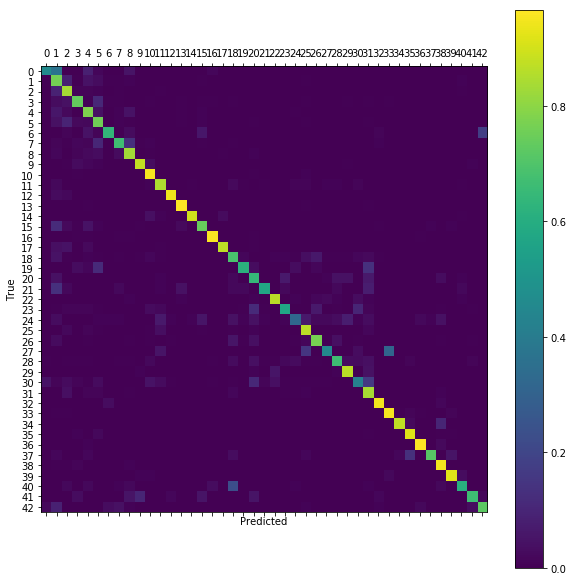

In [17]:
print_confusion_matrix(y_test, preds)